In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

In [ ]:
import os
import re
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json

In [ ]:
BASE_PATH = '/content/drive/MyDrive/ml-project/FaceDataset'
MODEL_DIR = BASE_PATH + '/model'

In [ ]:
images = []
image_ids = []
image_props = {}
labels_to_emotion = {0: 'anger',
                    1: 'disgust',
                    2: 'fear',
                    3: 'happy',
                    4: 'neutral',
                    5: 'sadness',
                    6: 'surprise'}

In [ ]:
! ls '/content/drive/MyDrive/ml-project/FaceDataset/fer'

fer2013.csv


Preparing FER images

In [ ]:
df_fer = pd.read_csv('/content/drive/MyDrive/ml-project/FaceDataset/fer/fer2013.csv')
df_fer['emotion_decoded'] = df_fer['emotion'].apply(lambda x: labels_to_emotion[x])
df_fer

,emotion,pixels,Usage,emotion_decoded
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,anger
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,anger
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,sadness
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral
...,...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest,neutral
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest,happy
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest,anger
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest,happy


FER Dataset


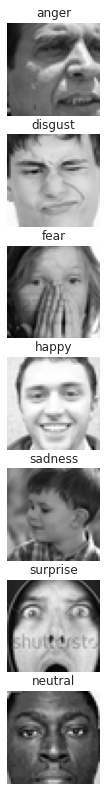

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
print('FER Dataset')
for label in sorted(df_fer['emotion'].unique()):
    for j in range(1):
        px = df_fer[df_fer.emotion==label].pixels.iloc[k + 4]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 1, k)
        ax.imshow(px, cmap='gray')
        ax.axis('off')
        ax.set_title(labels_to_emotion[label])
        # plt.tight_layout()

In [ ]:
img_array = df_fer['pixels'].apply(lambda x: np.array(x.split(' '))
            .reshape(48, 48, 1)
            .astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)

le = LabelEncoder()
img_labels = le.fit_transform(df_fer['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping # {3: 0, 4: 1, 6: 2}

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

### Approach 1

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

(32298, 48, 48, 3) (3589, 48, 48, 3) (32298, 7) (3589, 7)


In [ ]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

MC = ModelCheckpoint(MODEL_DIR + '/model_e_{epoch:02d}.hdf5',
                     save_best_only=True,
                     save_weights_only=True)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 50

optims = [
  optimizers.Adam(0.001),
]

In [ ]:
model = build_net(optims[0]) 

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:
hyp = model.predict(X_valid)
hyp

array([[4.99726385e-02, 6.83931925e-04, 5.66250861e-01, ...,
        4.87248488e-02, 1.40995011e-01, 6.40584379e-02],
       [3.54817341e-04, 1.11828044e-07, 3.78189608e-02, ...,
        2.24525051e-04, 9.61014271e-01, 2.75925675e-04],
       [6.15691915e-02, 1.91398175e-03, 1.75558388e-01, ...,
        8.67466070e-03, 7.42157936e-01, 4.89301793e-03],
       ...,
       [4.05693918e-01, 9.61725018e-04, 5.91696613e-02, ...,
        2.83119828e-01, 9.46217217e-04, 2.44725972e-01],
       [2.08265167e-02, 7.63988995e-04, 3.49943899e-02, ...,
        9.41392362e-01, 2.04855533e-05, 1.83249242e-03],
       [6.11027852e-02, 7.55468733e-04, 1.56640351e-01, ...,
        6.75959945e-01, 1.95097306e-03, 1.01738900e-01]], dtype=float32)

In [ ]:
np.argmax(y_valid[0])

2

In [ ]:
hyp[0]

array([0.04997264, 0.00068393, 0.56625086, 0.12931427, 0.04872485,
       0.14099501, 0.06405844], dtype=float32)

In [ ]:
np.argmax(hyp[0])

2

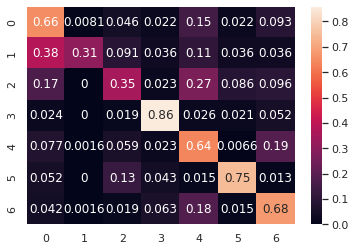

In [ ]:
# plotting heatmap
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

y_valid2 = [np.argmax(y) for y in y_valid]
hyp2 = [np.argmax(hy) for hy in hyp]

cm = confusion_matrix(y_valid2, hyp2, normalize="true")
sns.heatmap(cm, annot=True,xticklabels=le.classes_, yticklabels=le.classes_,)
plt.show()

In [ ]:
# compute f1 score
f1_score(y_valid2, hyp2, average='weighted')

0.6662018445724254

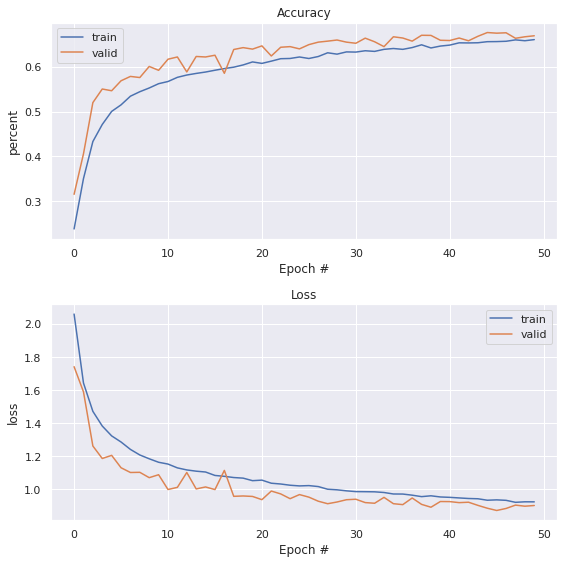

In [ ]:
sns.set()
fig = plt.figure(2, (8, 8))

ax = plt.subplot(2, 1, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('percent')
plt.tight_layout()

ax = plt.subplot(2, 1, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.tight_layout()

plt.savefig(MODEL_DIR + '/epoch_history_dcnn2.png')
plt.show()

In [ ]:
# saving the model
model_yaml = model.to_json()
with open(MODEL_DIR + "/model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save(MODEL_DIR + "/model.h5")

### Approach 2

In [ ]:
img_array = df_fer['pixels'].apply(lambda x: np.array(x.split(' '))
            .reshape(48, 48, 1)
            .astype('float32'))
img_array = [cv2.merge((img, img, img)) for img in img_array]
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
img_array[0].shape

(48, 48, 3)

In [ ]:
def build_advanced_net(model_weights=None, image_size: int = 224, classes: int = 7) -> Sequential:

    conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(image_size, image_size, 3))
    for layer in conv_base.layers[:-2]:
        layer.trainable = False
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    if model_weights is not None:
        print('Extracting models from path!')
        model.load_weights(model_weights)

    return model

In [ ]:
from keras.models import Model
from tensorflow.keras import regularizers

conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(48, 48, 3))
for layer in conv_base.layers[:-3]:
  layer.trainable = False
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001))(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(7, activation='softmax')(top_model)
    
model = Model(inputs=conv_base.input, outputs=output_layer)

model.compile(optimizer=optimizers.Adam(0.001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        

In [ ]:
img_array[0].shape

(48, 48, 3)

In [ ]:
# parameters
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARN_RATE = 0.001
TEST_RATIO = 0.2
SEED = 60
NUM_CLASSES = 7

In [ ]:
ES = EarlyStopping(monitor='val_loss',
                   patience=2)
MC = ModelCheckpoint(MODEL_DIR + '/model_e_{epoch:02d}.hdf5',
                     save_best_only=True,
                     save_weights_only=True)
print('[INFO] starting training...')
aug = ImageDataGenerator(rotation_range=0.2,
                             shear_range=0.15)

H = model.fit(aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
              epochs=NUM_EPOCHS,
              validation_data=aug.flow(X_valid, y_valid, batch_size=BATCH_SIZE),
              callbacks=[MC],
              verbose=1)

[INFO] starting training...
Epoch 1/50
505/505 [==============================] - 25s 47ms/step - loss: 1.9222 - accuracy: 0.2483 - val_loss: 1.8297 - val_accuracy: 0.2505
Epoch 2/50
505/505 [==============================] - 24s 47ms/step - loss: 1.8212 - accuracy: 0.2505 - val_loss: 1.8149 - val_accuracy: 0.2505
Epoch 3/50
505/505 [==============================] - 23s 46ms/step - loss: 1.8144 - accuracy: 0.2505 - val_loss: 1.8148 - val_accuracy: 0.2505
Epoch 4/50
505/505 [==============================] - 25s 49ms/step - loss: 1.8127 - accuracy: 0.2505 - val_loss: 1.8111 - val_accuracy: 0.2505
Epoch 5/50
505/505 [==============================] - 24s 48ms/step - loss: 1.8120 - accuracy: 0.2505 - val_loss: 1.8110 - val_accuracy: 0.2505
Epoch 6/50
505/505 [==============================] - 23s 46ms/step - loss: 1.8116 - accuracy: 0.2505 - val_loss: 1.8119 - val_accuracy: 0.2505
Epoch 7/50
505/505 [==============================] - 23s 46ms/step - loss: 1.8116 - accuracy: 0.2505 - val_

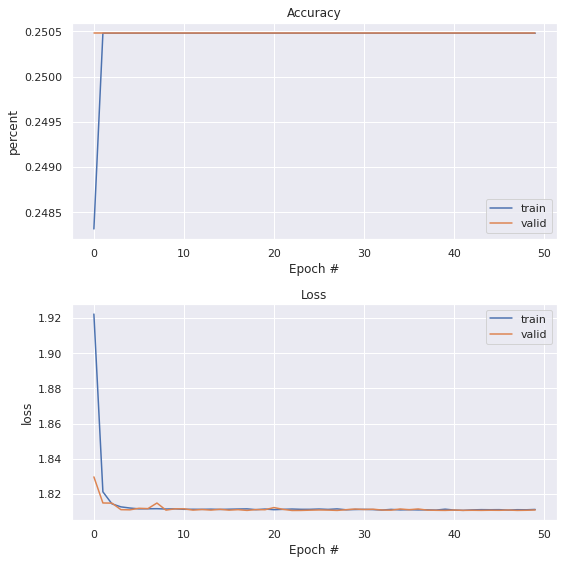

In [ ]:
import seaborn as sns

history = H

sns.set()
fig = plt.figure(2, (8, 8))

ax = plt.subplot(2, 1, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('percent')
plt.tight_layout()

ax = plt.subplot(2, 1, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.tight_layout()
plt.show()

In [ ]:
# baseModel = 
# for layer in baseModel.layers:
# 	layer.trainable = False
# headModel = baseModel.output
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(512, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(len(config.CLASSES), activation="softmax")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(0.001),
# 	metrics=["accuracy"])

In [ ]:
# net = Sequential(name='VGG16')
# conv_base = VGG16(include_top=False,
#                       weights='imagenet',
#                       input_shape=(224, 224, 3))
# for layer in conv_base.layers[:-2]:
#     layer.trainable = False
# net.add(conv_base)
# net.add(GlobalAveragePooling2D())

# net.add(
#         Conv2D(
#             filters=64,
#             kernel_size=(5,5),
#             input_shape=(img_width, img_height, img_depth),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_1'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_1'))
# net.add(
#         Conv2D(
#             filters=64,
#             kernel_size=(5,5),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_2'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_2'))
    
# net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
# net.add(Dropout(0.4, name='dropout_1'))

# net.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_3'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_3'))
# net.add(Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_4'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_4'))
    
# net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
# net.add(Dropout(0.4, name='dropout_2'))

# net.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_5'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_5'))
# net.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_6'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_6'))
    
# net.add(Dropout(0.5, name='dropout_3'))
# net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))

# net.add(Flatten(name='flatten'))
        
# net.add(
#         Dense(
#             128,
#             activation='elu',
#             kernel_initializer='he_normal',
#             name='dense_1'
#         )
#     )
# net.add(BatchNormalization(name='batchnorm_7'))
    
# net.add(Dropout(0.6, name='dropout_4'))
    
# net.add(
#         Dense(
#             num_classes,
#             activation='softmax',
#             name='out_layer'
#         )
#     )
    
# net.compile(
#         loss='categorical_crossentropy',
#         optimizer=optimizers.Adam(0.001),
#         metrics=['accuracy']
#     )
    
# net.summary()


ValueError: ignored

In [ ]:
# parameters
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARN_RATE = 0.001
TEST_RATIO = 0.2
SEED = 60
NUM_CLASSES = 7

In [ ]:
# img_array = df_images['Image2']
# img_array = np.stack(img_array, axis=0)
# img_array.shape

# X_train, X_valid, y_train, y_valid = train_test_split(
#     img_array, img_labels, 
#     test_size=TEST_RATIO, 
#     random_state=SEED
# )

In [ ]:
# augment images using image data generator
aug = ImageDataGenerator(rotation_range=0.2,
                         shear_range=0.15)

model = build_advanced_net()
model.summary()
optimizer = Adam(learning_rate=LEARN_RATE)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print('[INFO] model compiled.')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                16448     
                                                      

In [ ]:
# train model
ES = EarlyStopping(monitor='val_loss',
                   patience=2)
MC = ModelCheckpoint(MODEL_DIR + '/model_e_{epoch:02d}.hdf5',
                     save_best_only=True,
                     save_weights_only=True)
print('[INFO] starting training...')

H = model.fit(aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
              epochs=NUM_EPOCHS,
              validation_data=aug.flow(X_valid, y_valid, batch_size=BATCH_SIZE),
              callbacks=[ES, MC],
              verbose=1)
print('[INFO] model trained.')

[INFO] starting training...
Epoch 1/50
505/505 [==============================] - 26s 50ms/step - loss: 1.6393 - accuracy: 0.3570 - val_loss: 1.5417 - val_accuracy: 0.3976
Epoch 2/50
505/505 [==============================] - 25s 50ms/step - loss: 1.4712 - accuracy: 0.4348 - val_loss: 1.4373 - val_accuracy: 0.4508
Epoch 3/50
505/505 [==============================] - 24s 48ms/step - loss: 1.3894 - accuracy: 0.4679 - val_loss: 1.4448 - val_accuracy: 0.4394
Epoch 4/50
505/505 [==============================] - 25s 49ms/step - loss: 1.3249 - accuracy: 0.4977 - val_loss: 1.3662 - val_accuracy: 0.4714
Epoch 5/50
505/505 [==============================] - 24s 48ms/step - loss: 1.2708 - accuracy: 0.5243 - val_loss: 1.3880 - val_accuracy: 0.4712
Epoch 6/50
505/505 [==============================] - 25s 49ms/step - loss: 1.2292 - accuracy: 0.5406 - val_loss: 1.3496 - val_accuracy: 0.4907
Epoch 7/50
505/505 [==============================] - 24s 48ms/step - loss: 1.1821 - accuracy: 0.5612 - val_

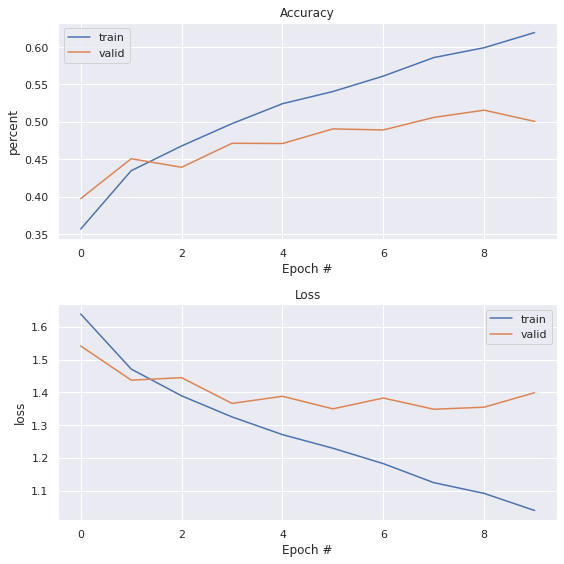

In [ ]:
import seaborn as sns

history = H

sns.set()
fig = plt.figure(2, (8, 8))

ax = plt.subplot(2, 1, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('percent')
plt.tight_layout()

ax = plt.subplot(2, 1, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.tight_layout()
plt.show()

### Testing out with different videos

In [ ]:
!pip install face_recognition

import os
import sys
import shutil
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import face_recognition


video_filepath = '/content/drive/MyDrive/ml-project/goodbye toby.mp4'

     |████████████████████████████████| 100.1 MB 37 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=1aa8ffcbdb451815550df9e7bba7a2315b1badbe586f392474bf996b9b52bf7e
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


Change here for the frame

In [ ]:
selected_frame = 2

In [ ]:
frames_req = 5

all_video_faces = []

from dlib import get_frontal_face_detector
import time

hog_face_detector = get_frontal_face_detector()

def hog_detect_face(image, hog_face_detector, display = True):
    '''
    This function performs face(s) detection on an image using dlib hog face detector.
    Args:
        image:             The input image of the person(s) whose face needs to be detected.
        hog_face_detector: The hog face detection model required to perform the detection on the input image.
        display:           A boolean value that is if set to true the function displays the original input image, 
                           and the output image with the bounding boxes drawn and time taken written and returns nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    # Get the height and width of the input image.
    height, width, _ = image.shape
    # Create a copy of the input image to draw bounding boxes on.
    output_image = image.copy()
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    # Perform the face detection on the image.
    results = hog_face_detector(imgRGB, 0)

    faces = []

    # Loop through the bounding boxes of each face detected in the image.
    for bbox in results:    
        # Retrieve the left most x-coordinate of the bounding box.
        x1 = bbox.left()
        # Retrieve the top most y-coordinate of the bounding box.
        y1 = bbox.top()
        # Retrieve the right most x-coordinate of the bounding box.
        x2 = bbox.right()
        # Retrieve the bottom most y-coordinate of the bounding box.       
        y2 = bbox.bottom()

        cimg = imgRGB[y1:y2, x1:x2]
        try:
            cimg_resized = cv2.resize(cimg, (48, 48))
            cimg = cimg_resized
            faces.append(cimg)
            # Draw a rectangle around a face on the copy of the image using the retrieved coordinates.
            cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=width//200)
        except:
            print("could not resize image!")
    
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        # Return the output image and results of face detection.
        return faces

def get_frame(sec, vid_cap, count, output_directory, filename, output_ext):
    # since we are only selecting the middle frame now
    if count != selected_frame:
      return True
    vid_cap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    has_frames, image = vid_cap.read()

    if has_frames:
        # TODO - we need to get all faces from the frame and write that
        faces = hog_detect_face(image, hog_face_detector, display=False)
        if faces is not None and len(faces) != 0:
            num_faces = len(faces)
            face_count = 1
            for face in faces:
                all_video_faces.append(face)
    return has_frames

def convert_video_to_frames(video_file, output_directory, output_ext="jpg"):
    all_video_faces = []

    """Converts video to multiple frames using OpenCV library"""
    filename, ext = os.path.splitext(video_file)
    vid_cap = cv2.VideoCapture(video_file)
    
    frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid_cap.get(cv2.CAP_PROP_FPS) 
    filename = filename.split('/')[-1]
    
    if fps == 0 or frame_count == 0:
        print("No frames in {}. Skipping!".format(filename))
        return
    
    sec = 0
    frame_rate = frame_count / (frames_req * fps)
    count = 1
    
    # print("Getting frames for {}".format(filename))
    success = get_frame(sec, vid_cap, count, output_directory, filename, output_ext)
    
    while success:
        count = count + 1
        sec = sec + frame_rate
        sec = round(sec, 2)
        
        if count > frames_req:
            break
        
        success = get_frame(sec, vid_cap, count, output_directory, filename, output_ext)

convert_video_to_frames(video_filepath, '')
print("Number of faces: ", len(all_video_faces))

Number of faces:  1


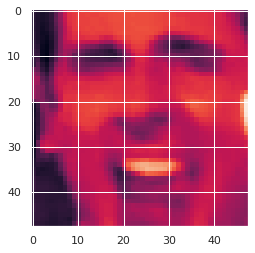

In [ ]:
for face in all_video_faces:
    plt.imshow(face)

In [ ]:
test_img_array = [np.array(face).reshape(48, 48, 1) for face in all_video_faces] 
test_img_array = [cv2.merge((img, img, img)) for img in test_img_array]
test_img_array = np.stack(test_img_array, axis=0)
test_img_array.shape # (21264, 48, 48, 1)

test_img_array = test_img_array / 255.

test_hyp = model.predict(test_img_array)
test_hyp

array([[0.26917496, 0.01420634, 0.0882017 , 0.5218336 , 0.08380373,
        0.00494841, 0.0178312 ]], dtype=float32)

In [ ]:
print("The image is describing: {}".format(labels_to_emotion[np.argmax(test_hyp)]))

The image is describing: happy
